# Mushroom Cultivation Analysis
Alessio Carnevale, Manuel Cattoni

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb
from scipy import stats

from functions import log_lik, lik, neg_log_lik, neg_lik, log_prior, log_posterior, neg_log_posterior

# 1. Probabilistic Model

TODO:

need to derive the full probabilistic model. (check md file)


binomial dist

# 1.2 Maximum Likelihood estimation

In [21]:
x = np.array([2, 8, 15, 25])    # Storage temperatures
n = np.array([30, 25, 20, 30])  # Total mushrooms
y = np.array([2, 4, 5, 20])     # Spoiled mushrooms

The **likelihood** is:

$$
L(\alpha, \beta)
= \prod_{i=1}^n 
\binom{n_i}{y_i}\,
p_i^{\,y_i}\,
(1 - p_i)^{\,n_i - y_i},
$$

where

$$
p_i = \frac{1}{1 + e^{-(\alpha + \beta x_i)}}.
$$


The **log-likelihood** used in the code is

$$
\ell(\alpha, \beta)
= \sum_{i=1}^N 
\log\!\Bigg[
\binom{n_i}{y_i}\,
p_i^{\,y_i}\,
(1 - p_i)^{\,n_i - y_i}
\Bigg],
$$

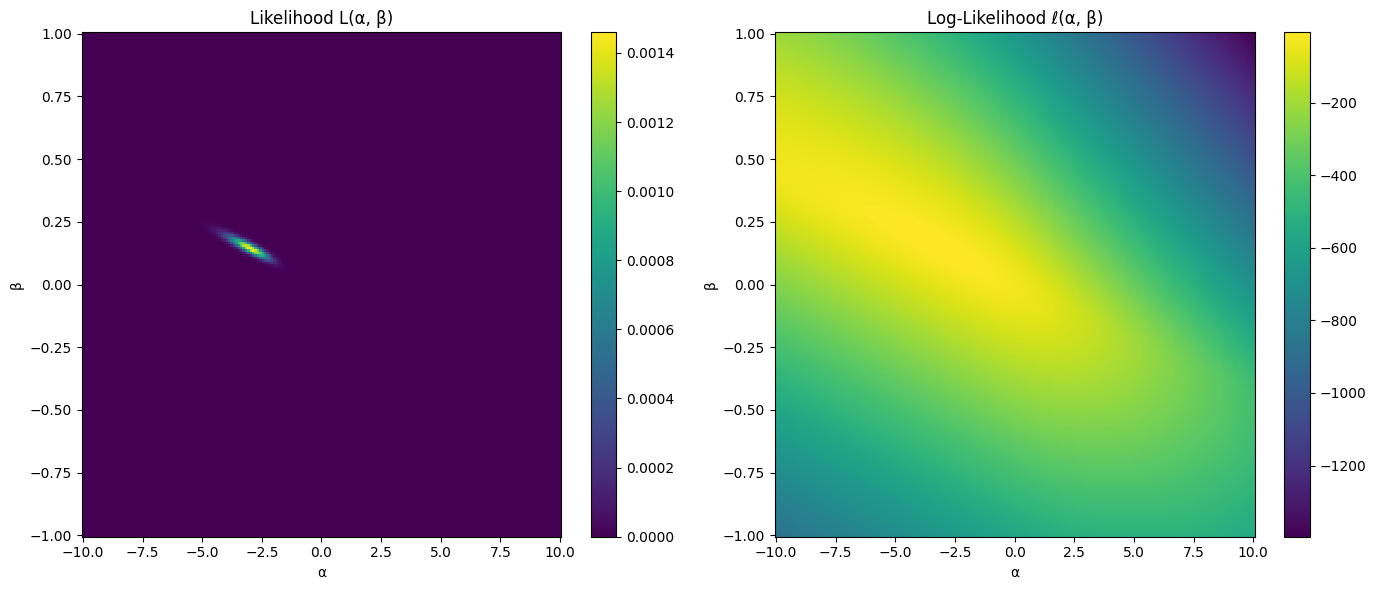

In [22]:
theta = np.array([0.1, 0.05])

# Grid ranges
alpha_vals = np.linspace(-10, 10, 200)
beta_vals = np.linspace(-1, 1, 200)

A, B = np.meshgrid(alpha_vals, beta_vals)

L = np.zeros_like(A)
LL = np.zeros_like(A)

# Compute likelihoods 
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        theta = (A[i, j], B[i, j])
        L[i, j] = lik(theta, x, y, n)
        LL[i, j] = log_lik(theta, x, y, n)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pc1 = axes[0].pcolormesh(A, B, L, shading='auto')
axes[0].set_title("Likelihood L(α, β)")
axes[0].set_xlabel("α")
axes[0].set_ylabel("β")
fig.colorbar(pc1, ax=axes[0])

pc2 = axes[1].pcolormesh(A, B, LL, shading='auto')
axes[1].set_title("Log-Likelihood ℓ(α, β)")
axes[1].set_xlabel("α")
axes[1].set_ylabel("β")
fig.colorbar(pc2, ax=axes[1])

plt.tight_layout()
plt.show()


The likelihood function produces extremely small values. The surface is essentially zero everywhere beside a tiny area.

The log-likelihood however shows a smooth, continuous gradient spreading across the entire parameter space, clearly representing the geometry of this optimization problem. The logarithm brings the values into a manageable numerical range.

### Maximum Likelihood
minimizing the negative log-likelihood because it avoids issues that can arise when working with very small likelihood values

In [23]:
from scipy.optimize import minimize



initial_guess = [0.1, 0.05]

result = minimize(neg_log_lik, initial_guess, (x, y, n), method='BFGS')

alpha_ml, beta_ml = result.x

print(f"Maximum Likelihood Estimates: α_ML = {alpha_ml:.4f}, β_ML = {beta_ml:.4f}")

Maximum Likelihood Estimates: α_ML = -2.9776, β_ML = 0.1439


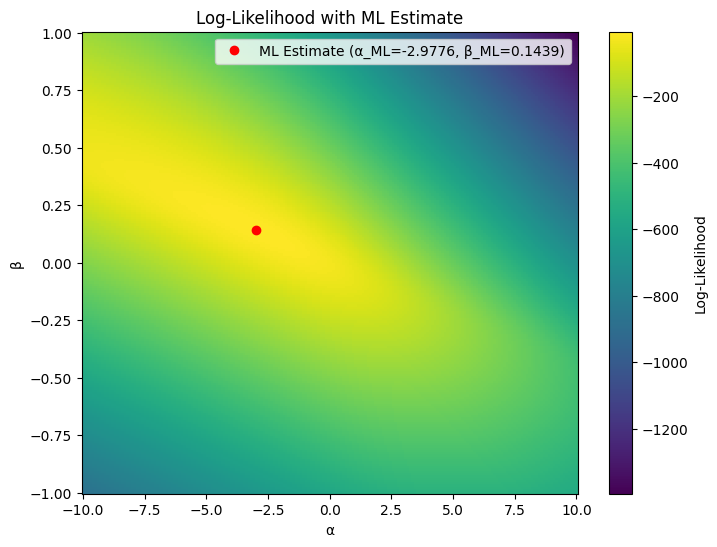

In [24]:
# Plot the likelihood function with the ML estimate
fig, ax = plt.subplots(figsize=(8, 6))

pc = ax.pcolormesh(A, B, LL, shading='auto', cmap="viridis")
ax.set_title("Log-Likelihood with ML Estimate")
ax.set_xlabel("α")
ax.set_ylabel("β")
fig.colorbar(pc, ax=ax, label="Log-Likelihood")

# Overlay the ML estimate
ax.plot(alpha_ml, beta_ml, 'ro', label=f"ML Estimate (α_ML={alpha_ml:.4f}, β_ML={beta_ml:.4f})")
ax.legend()

plt.show()

TODO: need to comment this plot

# Maximum A Posteriori Estimation

### Posterior (up to θ‑independent factor)


TODO: Derive an analytical expression of the posterior 𝑓(𝜃 ∣ 𝑦), up to a multiplicative factor not
depending on 𝜃.

## Log-posterior g(θ) = log f(θ | y) (up to additive constant)

TODO: Derive an analytical expression of the log-posterior 𝑔(𝜃) = log 𝑓(𝜃 ∣ 𝑦), up to an additive
factor not depending on 𝜃.



TODO: check sigma prior values

ML Estimates:  α = -2.9776, β = 0.1439
MAP Estimates: α = -2.9683, β = 0.1435
Differences:   Δα = 0.0093, Δβ = 0.0004


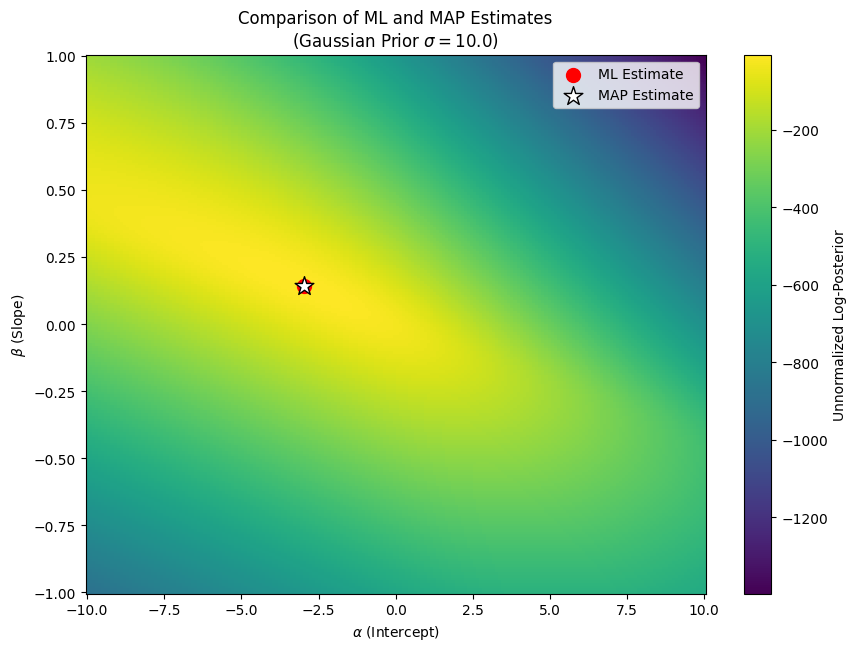

In [25]:
sigma_prior = 10.0

# Compute ML Estimate
res_ml = minimize(neg_log_lik, initial_guess, (x,y,n), method='BFGS')
alpha_ml, beta_ml = res_ml.x

# Compute MAP Estimate
res_map = minimize(neg_log_posterior, initial_guess,(x,y,n), method='BFGS')
alpha_map, beta_map = res_map.x

delta_alpha = abs(alpha_map - alpha_ml)
delta_beta = abs(beta_map - beta_ml)

print(f"ML Estimates:  α = {alpha_ml:.4f}, β = {beta_ml:.4f}")
print(f"MAP Estimates: α = {alpha_map:.4f}, β = {beta_map:.4f}")
print(f"Differences:   Δα = {delta_alpha:.4f}, Δβ = {delta_beta:.4f}")

# Compute posterior values on the grid
Z = np.zeros_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        # We compute the value for every point on the grid
        Z[i, j] = log_posterior([A[i, j], B[i, j]], x, y, n)

plt.figure(figsize=(10, 7))

# Plot unnormalized log-posterior 
pc = plt.pcolormesh(A, B, Z, shading='auto', cmap='viridis')
plt.colorbar(pc, label='Unnormalized Log-Posterior')

plt.scatter(alpha_ml, beta_ml, color='red', marker='o', s=100, label='ML Estimate', zorder=5)
plt.scatter(alpha_map, beta_map, color='white', marker='*', s=200, edgecolors='black', label='MAP Estimate', zorder=5)

plt.title(f'Comparison of ML and MAP Estimates\n(Gaussian Prior $\\sigma={sigma_prior}$)')
plt.xlabel('$\\alpha$ (Intercept)')
plt.ylabel('$\\beta$ (Slope)')
plt.legend()
plt.show()

# 1.3 Brute-force posterior estimation

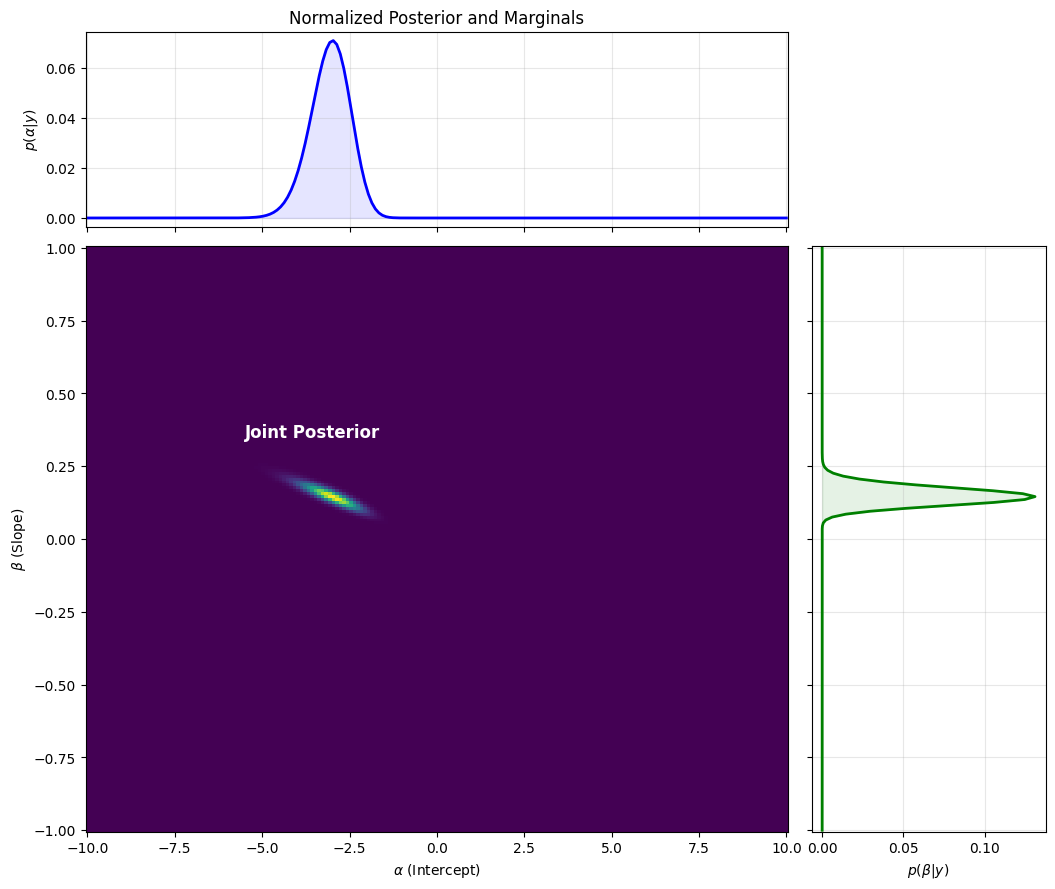

In [27]:
from scipy.special import logsumexp

# Compute unnormalized log-posterior on the grid
log_post_grid = np.zeros_like(A)

for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        # We use the existing log_lik function here
        theta = [A[i, j], B[i, j]]
        log_post_grid[i, j] = log_posterior(theta, x, y, n)

# --- Normalization Step ---
# We use the LogSumExp trick for numerical stability
# Normalization constant (in log domain):
log_evidence = logsumexp(log_post_grid)

# Normalized log-posterior:
log_post_norm = log_post_grid - log_evidence

# Exponentiate to get probabilities:
posterior_norm = np.exp(log_post_norm)

# --- Marginalization ---
# Summing probability mass to get marginal distributions

# Marginal for alpha (sum over beta rows)
marginal_alpha = np.sum(posterior_norm, axis=0) 

# Marginal for beta (sum over alpha columns)
marginal_beta = np.sum(posterior_norm, axis=1)

# --- Visualization ---

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# 1. Main Plot: Joint Normalized Posterior
ax_joint = fig.add_subplot(gs[1, 0])
# Using pcolormesh as requested in previous turn
pc = ax_joint.pcolormesh(A, B, posterior_norm, shading='auto', cmap='viridis')
ax_joint.set_xlabel(r'$\alpha$ (Intercept)')
ax_joint.set_ylabel(r'$\beta$ (Slope)')
ax_joint.text(-5.5, 0.35, 'Joint Posterior', color='white', fontsize=12, fontweight='bold')

# 2. Top Plot: Marginal Posterior for Alpha
ax_alpha = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_alpha.plot(alpha_vals, marginal_alpha, color='blue', lw=2)
ax_alpha.fill_between(alpha_vals, 0, marginal_alpha, color='blue', alpha=0.1)
ax_alpha.set_ylabel(r'$p(\alpha | y)$')
ax_alpha.set_title('Normalized Posterior and Marginals')
plt.setp(ax_alpha.get_xticklabels(), visible=False)
ax_alpha.grid(True, alpha=0.3)

# 3. Right Plot: Marginal Posterior for Beta
ax_beta = fig.add_subplot(gs[1, 1], sharey=ax_joint)
ax_beta.plot(marginal_beta, beta_vals, color='green', lw=2)
ax_beta.fill_betweenx(beta_vals, 0, marginal_beta, color='green', alpha=0.1)
ax_beta.set_xlabel(r'$p(\beta | y)$')
plt.setp(ax_beta.get_yticklabels(), visible=False)
ax_beta.grid(True, alpha=0.3)

plt.show()

not sure about this